In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import kagglehub
zippyz_cats_and_dogs_breeds_classification_oxford_dataset_path = kagglehub.dataset_download('zippyz/cats-and-dogs-breeds-classification-oxford-dataset')

100%|██████████| 780M/780M [00:40<00:00, 20.3MB/s]

Extracting files...


In [3]:
print(zippyz_cats_and_dogs_breeds_classification_oxford_dataset_path)
print('Data source import complete.')

/root/.cache/kagglehub/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1
Data source import complete.


In [4]:
# Importing core libraries
import numpy as np  # For numerical array operations
import pandas as pd  # For data analysis and manipulation
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For statistical visualizations
import tensorflow as tf  # Machine learning library
import cv2  # For image and video processing
from PIL import Image  # For image loading and processing

# Importing Keras modules for deep learning
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image augmentation
from tensorflow.keras.models import Sequential  # For building sequential models
from tensorflow.keras.layers import (  # For defining model layers
    Dense,  # Fully connected layer
    Conv2D,  # Convolutional layer for feature extraction
    Flatten,  # Flatten layer to convert 2D to 1D
    GlobalMaxPooling2D,  # Global max pooling layer
    AveragePooling2D,  # Average pooling layer
    GlobalAveragePooling2D,  # Global average pooling layer
    Dropout,  # Dropout layer for regularization
)
from tensorflow.keras.applications import ResNet50, MobileNetV2  # Pre-trained models for transfer learning
from tensorflow.keras.callbacks import (  # For training optimization
    ReduceLROnPlateau,  # Reduce learning rate on plateau
    ModelCheckpoint,  # Save the best model during training
    EarlyStopping,  # Stop training early if no improvement
)
from tensorflow.keras.optimizers import Adam  # Optimizer for training

# Importing metrics for model evaluation
from sklearn.metrics import (
    precision_score,  # Precision metric
    recall_score,  # Recall metric
    confusion_matrix,  # Confusion matrix for classification results
    ConfusionMatrixDisplay,  # To visualize the confusion matrix
    classification_report,  # Detailed classification report
    accuracy_score,  # Accuracy metric
    f1_score,  # F1-score metric
)

import seaborn as sns

# Ignore warnings to keep the output clean
import warnings
warnings.filterwarnings("ignore")


In [5]:
# Define image shape constants
IMG_SHAPE = (250, 250)  # Image dimensions (height, width)
IMG_SHAPE_CHANNELS = (250, 250, 3)  # Image dimensions with channels (height, width, channels)

# Reading the annotations CSV file
annotations_path = '/root/.cache/kagglehub/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1/annotations/annotations/list.txt'
annotations_df = pd.read_csv(annotations_path)

# Extracting dataset information from the first 4 rows
dataset_info = annotations_df.head(4).copy()

# Reading the data after the 5th row (actual data entries)
annotations_df = annotations_df.iloc[5:, :].reset_index(drop=True)

# Splitting the combined column into separate fields
columns_to_split = '#Image CLASS-ID SPECIES BREED ID'
annotations_df[['Image_Name', 'Class_ID', 'Species', 'Breed_ID']] = annotations_df[columns_to_split].str.split(expand=True)

# Dropping the original combined column
annotations_df.drop(columns=columns_to_split, inplace=True)

# Renaming columns for clarity and consistency
annotations_df.rename(columns={
    "Image_Name": "Image",
    "Class_ID": "Class_ID",
    "Species": "Species",
    "Breed_ID": "Breed_ID"
}, inplace=True)

# Converting specific columns to integer type
int_columns = ["Class_ID", "Species", "Breed_ID"]
annotations_df[int_columns] = annotations_df[int_columns].astype(int)

# Displaying the processed DataFrame's head for verification
print(annotations_df.head())


            Image  Class_ID  Species  Breed_ID
0  Abyssinian_100         1        1         1
1  Abyssinian_101         1        1         1
2  Abyssinian_102         1        1         1
3  Abyssinian_103         1        1         1
4  Abyssinian_104         1        1         1


In [6]:
# Function to visualize breed distribution as a pie chart
def plot_breed_pie_chart(dataframe, plot_title):
    """
    Plots a pie chart for the distribution of breeds.

    Parameters:
        dataframe (DataFrame): The DataFrame containing breed data.
        plot_title (str): The title for the plot.
    """
    # Count occurrences of each breed
    breed_counts = dataframe['classname'].value_counts()

    # Plotting the pie chart for breed distribution
    plt.figure(figsize=(10, 12))
    plt.pie(breed_counts.values, labels=breed_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("viridis", len(breed_counts)))
    plt.title(f'Breed Distribution: {plot_title}', fontsize=16)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


In [7]:
# Adding '.jpg' extension to the 'Image' column values in annotations_df
annotations_df['Image'] = annotations_df['Image'].apply(lambda x: str(x) + '.jpg')

# Resetting the index of the DataFrame 'annotations_df' and creating a new DataFrame 'df'
df = annotations_df.reset_index()

# Dropping the 'index' column which is automatically added when resetting the index
df = df.drop('index', axis=1)

# Display the resulting DataFrame
df

Image  Class_ID  Species  Breed_ID
0           Abyssinian_100.jpg         1        1         1
1           Abyssinian_101.jpg         1        1         1
2           Abyssinian_102.jpg         1        1         1
3           Abyssinian_103.jpg         1        1         1
4           Abyssinian_104.jpg         1        1         1
...                        ...       ...      ...       ...
7344  yorkshire_terrier_96.jpg        37        2        25
7345  yorkshire_terrier_97.jpg        37        2        25
7346  yorkshire_terrier_98.jpg        37        2        25
7347  yorkshire_terrier_99.jpg        37        2        25
7348   yorkshire_terrier_9.jpg        37        2        25

[7349 rows x 4 columns]

In [8]:
#Extracting the classname/breed of the animal
df['classname'] = df['Image'].apply(lambda x: str(x)[0:str(x).index('_')])

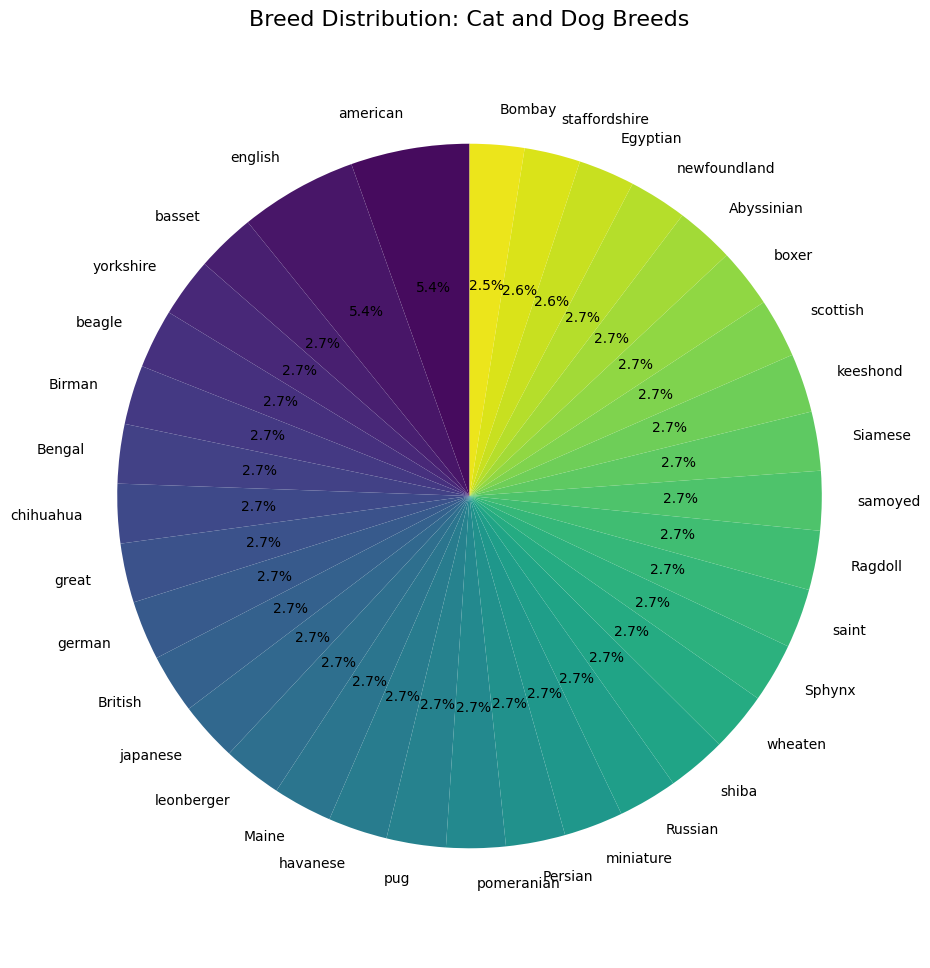

In [9]:
plot_breed_pie_chart(df, "Cat and Dog Breeds")

In [10]:
# Filter the dataframe for cats (SPECIES == 1)
df_cat = df[df['Species'] == 1]  # SPECIES value 1 represents cats

# Filter the dataframe for dogs (SPECIES == 2)
df_dog = df[df['Species'] == 2]  # SPECIES value 2 represents dogs

# Print the number of samples (rows) for cats
print("Number of samples in df_cat: ", df_cat.shape[0])

# Print the number of samples (rows) for dogs
print("Number of samples in df_dog: ", df_dog.shape[0])

Number of samples in df_cat:  2371
Number of samples in df_dog:  4978


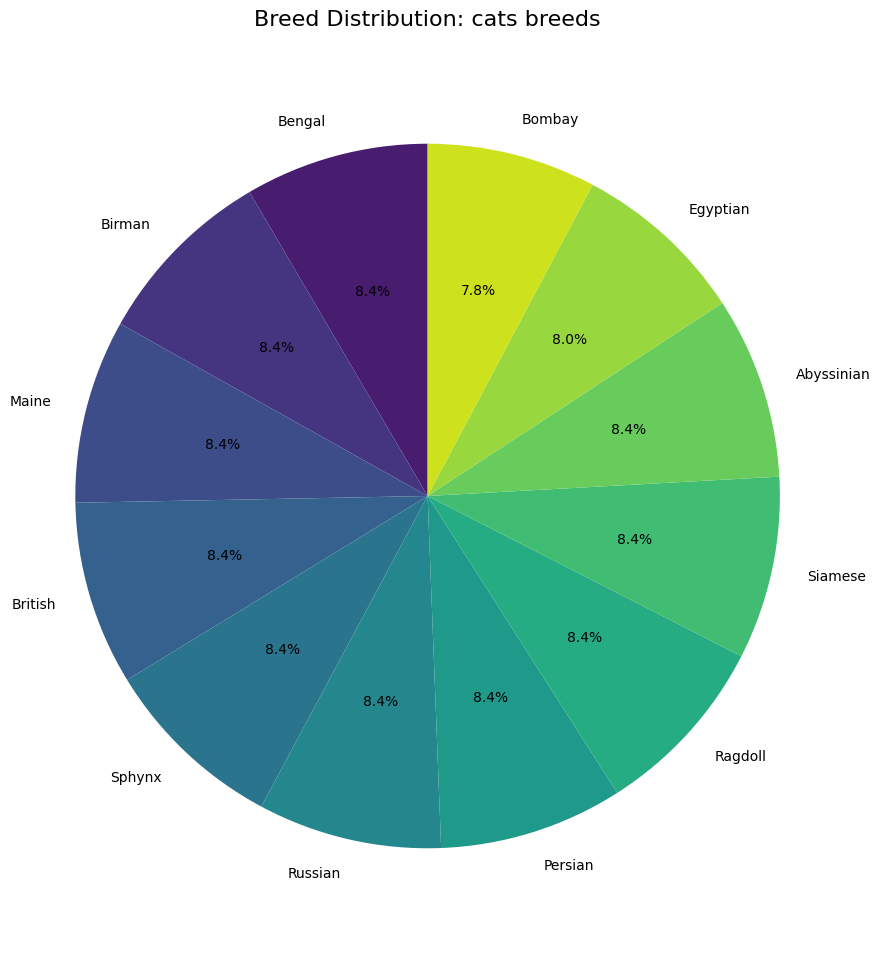

In [11]:
# Call the breed_count function to analyze breed distribution in cats
plot_breed_pie_chart(df_cat, "cats breeds")

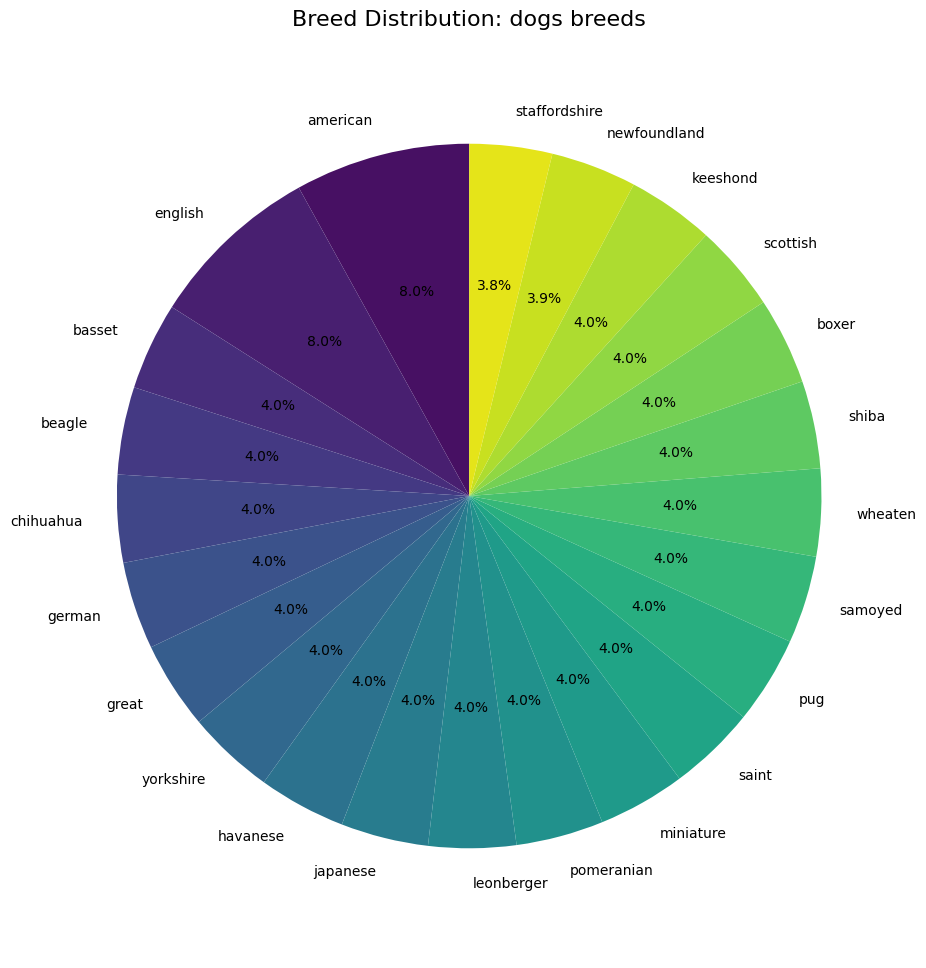

In [12]:
# Call the breed_count function to analyze breed distribution in dogs
plot_breed_pie_chart(df_dog, "dogs breeds")

In [13]:
import cv2
import numpy as np
import tensorflow as tf

# Function to process the image (input) for the model
def process(img):
    """
    Pre-processes the input image for model inference.

    Steps:
    1. Converts image from BGR to RGB format.
    2. Resizes the image to 250x250 pixels to match the model's input size.
    3. Applies MobileNet's preprocessing for scaling and normalization.
    4. Expands the image dimensions to create a batch of size 1.

    Args:
    - img (numpy array): The input image in BGR format.

    Returns:
    - numpy array: The preprocessed image ready for model input.
    """
    try:
        # Convert the image from BGR (OpenCV default) to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize the image to the target size of 250x250 pixels
        img = cv2.resize(img, (250, 250))

        # Preprocess the image for MobileNet model (scaling, centering, etc.)
        img = tf.keras.applications.mobilenet.preprocess_input(img)

        # Expand dimensions to create a batch of size 1
        img = np.expand_dims(img, axis=0)

        return img

    except Exception as e:
        print(f"Error during image processing: {e}")
        return None

# Function to read an image from the specified path
def get_image(path):
    """
    Reads an image from a file path and converts it to RGB format.

    Args:
    - path (str): The file path to the image.

    Returns:
    - numpy array: The image in RGB format, or None if the image could not be read.
    """
    try:
        # Read the image using OpenCV (returns None if the image is not found)
        image = cv2.imread(path)

        # Check if the image was successfully loaded
        if image is None:
            print(f"Error: Image at '{path}' could not be loaded.")
            return None

        # Convert the image from BGR to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        return image

    except Exception as e:
        print(f"Error reading the image at '{path}': {e}")
        return None


In [14]:
def visualize_classifications(datagen, row_col_len=4, figsize=None):
    """
    Visualizes the true labels of a random set of images without using the model.

    Args:
    - datagen (ImageDataGenerator): The data generator that provides the images and labels.
    - row_col_len (int): The number of rows and columns for the plot grid (default is 4).
    - figsize (tuple): The size of the figure (optional). If None, it is calculated based on row_col_len.
    """
    try:
        # Randomly select indices for images to display
        random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)

        # Retrieve class labels for the selected indices
        classes = np.array(list(datagen.class_indices))
        labels = classes[np.array(datagen.labels)[random_indexes]]

        # Get file paths of the selected images
        filepaths = pd.Series(datagen.filenames)[random_indexes]
        filepaths = "/root/.cache/kagglehub/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1/images/images/" + filepaths

        # Load images from the file paths
        images = filepaths.apply(get_image).reset_index(drop=True)

        # Set up the figure size for the plot
        figsize = figsize or np.array((row_col_len, row_col_len)) * 4
        fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)

        # Loop through the grid and display images with true labels
        for i in range(row_col_len):
            for j in range(row_col_len):
                sample_index = i * row_col_len + j
                ax[i, j].imshow(images[sample_index])  # Display the image
                # Set the title to show true labels
                ax[i, j].set_title(f"Y true({labels[sample_index]})")
                ax[i, j].set_axis_off()  # Hide the axes for better visualization

        # Show the plot with images and true labels
        plt.tight_layout()  # Ensure the subplots don't overlap
        plt.show()

    except Exception as e:
        print(f"Error in visualizing classifications: {e}")


In [15]:
# Data Augmentation for the training set
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,  # Preprocessing for MobileNetV2
    shear_range=0.2,            # Shear transformations
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Horizontal flip
    vertical_flip=True,         # Vertical flip
    validation_split=0.2,       # Validation split from data
    rotation_range=90,          # Rotation range
    width_shift_range=0.2,      # Horizontal shift
    height_shift_range=0.2      # Vertical shift
)

# Data generator for the validation set (no augmentation, only preprocessing)
validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,  # Preprocessing for MobileNetV2
    validation_split=0.2        # Validation split from data
)

In [16]:
# Function to create training and validation data generators from a dataframe
def datagen_flow_dataframe(df, train_datagen, validation_datagen, img_shape=IMG_SHAPE):
    """
    Creates training and validation data generators from a dataframe.

    Args:
    - df (pd.DataFrame): DataFrame containing image paths and their respective class labels.
    - train_datagen (ImageDataGenerator): ImageDataGenerator for the training data with augmentation.
    - validation_datagen (ImageDataGenerator): ImageDataGenerator for the validation data with no augmentation.
    - img_shape (tuple): Target image size (default is IMG_SHAPE).

    Returns:
    - train_gen_flow (DirectoryIterator): Training data generator.
    - valid_gen_flow (DirectoryIterator): Validation data generator.
    """
    try:
        # Create training data generator
        train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=df,                                # Input dataframe
            directory='/root/.cache/kagglehub/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1/images/images',  # Image directory
            x_col="Image",                                # Column containing image file names
            y_col="classname",                            # Column containing class labels
            target_size=img_shape,                        # Resize images to target size
            batch_size=32,                                # Batch size for training
            class_mode="categorical",                     # For multi-class classification
            subset='training',                            # Use 'training' subset from the dataframe
        )

        # Create validation data generator
        valid_gen_flow = validation_datagen.flow_from_dataframe(
            dataframe=df,                                # Input dataframe
            directory='/root/.cache/kagglehub/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1/images/images',  # Image directory
            x_col="Image",                                # Column containing image file names
            y_col="classname",                            # Column containing class labels
            target_size=img_shape,                        # Resize images to target size
            batch_size=32        ,                        # Batch size for validation
            class_mode="categorical",                     # For multi-class classification
            subset='validation',                          # Use 'validation' subset from the dataframe
            shuffle=False                                 # Do not shuffle validation data
        )

        # Return the training and validation generators
        return train_gen_flow, valid_gen_flow

    except Exception as e:
        print(f"Error while creating data generators: {e}")
        return None, None

In [17]:
train_gen_flow_cat, valid_gen_flow_cat = datagen_flow_dataframe(df_cat,train_datagen,validation_datagen)

Found 1897 validated image filenames belonging to 12 classes.
Found 474 validated image filenames belonging to 12 classes.


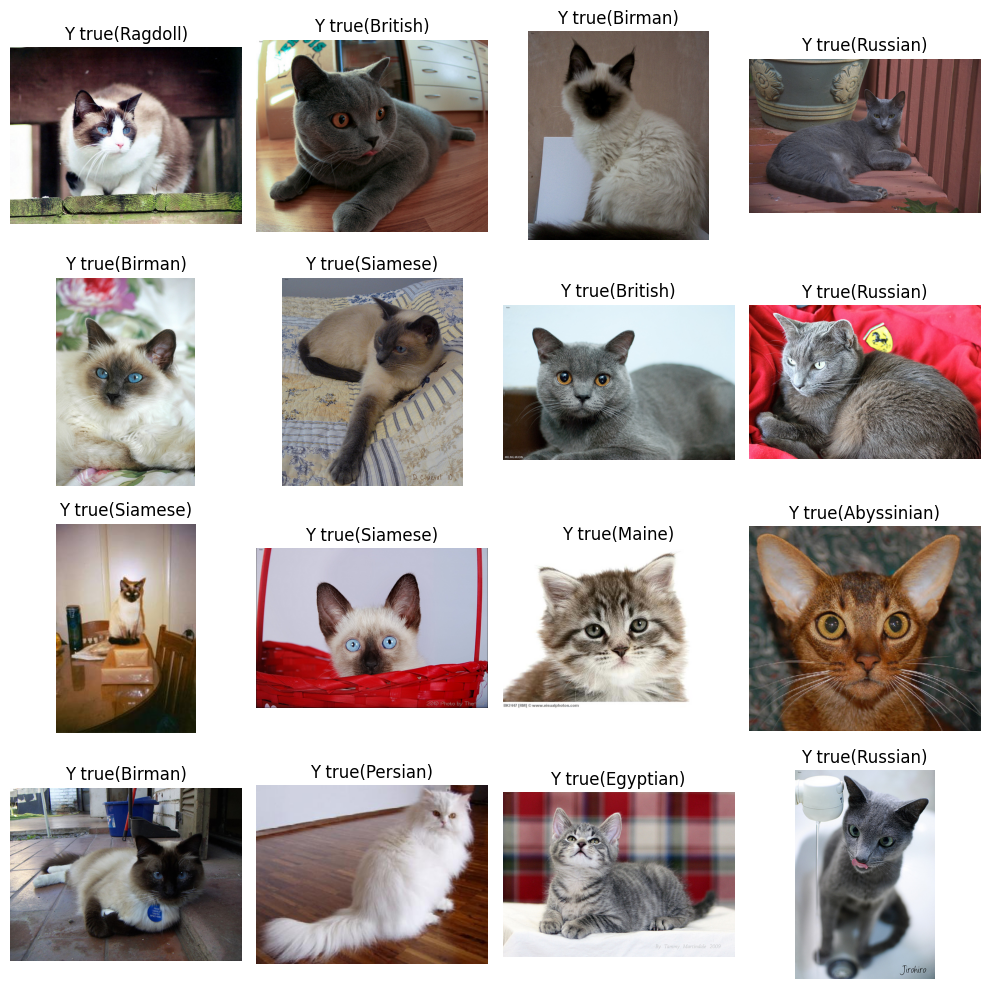

In [18]:
# Visualize classifications for the 'cat' class using the data generator
visualize_classifications(train_gen_flow_cat, row_col_len=4, figsize=(10, 10))

In [ ]:
def train_model(model, train_generator, validation_generator, epochs, name):
    """
    Trains the model with specified training and validation data generators, epochs, and saves the model weights.

    Args:
    - model (Keras model): The model to train.
    - train_generator (ImageDataGenerator): The training data generator.
    - validation_generator (ImageDataGenerator): The validation data generator.
    - epochs (int): The number of epochs for training.
    - name (str): The name to save the model weights file.

    Returns:
    - history: The history object containing the training and validation metrics.
    """
    # Change the file extension to .keras
    path_cp = name + '_weights.keras'

    # Learning rate reduction callback
    rlr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=4,
        verbose=1,
        min_delta=1e-4,
        min_lr=1e-4,
        mode='min',
        cooldown=1
    )

    # Model checkpoint callback to save the best weights
    ckp = ModelCheckpoint(
        path_cp,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )

    # Early stopping callback
    es = EarlyStopping(
        monitor='val_loss',
        min_delta=1e-4,
        patience=7,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    # Fitting the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        verbose=1,
        callbacks=[rlr, es, ckp]
    )

    return history


In [ ]:
# Load the MobileNetV2 model pre-trained on ImageNet without the top classification layer
pretrainedModel_cat = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE_CHANNELS,        # Shape of the input images (height, width, channels)
    include_top=False,                # Do not include the final fully connected layers (top layer)
    weights='imagenet',               # Load pre-trained weights from ImageNet
    pooling='avg'                     # Use global average pooling for feature extraction
)

# Freeze the base model to prevent its weights from being updated during training
pretrainedModel_cat.trainable = False

# Define the input layer to connect to the MobileNetV2 model
inputs = pretrainedModel_cat.input

# Add custom fully connected layers on top of the base model for the specific task
x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel_cat.output)  # 128 units, ReLU activation
x = tf.keras.layers.Dense(64, activation='relu')(x)                           # 64 units, ReLU activation

# Output layer: 12 classes (assuming multi-class classification), softmax for probabilities
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

# Define the final model with the base model input and custom output
model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with categorical crossentropy loss (for multi-class classification)
model_1.compile(
    loss='categorical_crossentropy',          # Loss function for multi-class classification
    optimizer=tf.optimizers.Adam(learning_rate=0.01),  # Adam optimizer with learning rate of 0.01
    metrics=['acc']                           # Metric for evaluation: accuracy
)

# Display model summary to check the layers and parameters
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 250, 250, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 125, 125, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 125, 125, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 125, 125, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 125, 125, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 125, 125, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 125, 125, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 125, 125, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 125, 125, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 125, 125, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 125, 125, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 125, 125, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 127, 127, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 63, 63, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,430,988 (9.27 MB)

 Trainable params: 173,004 (675.80 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
train_history = train_model(model_1, train_gen_flow_cat, valid_gen_flow_cat, epochs = 60 , name="cat" )

Epoch 1/60
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - acc: 0.3900 - loss: 2.0768
Epoch 1: val_loss improved from inf to 0.66263, saving model to cat_weights.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 602ms/step - acc: 0.3952 - loss: 2.0537 - val_acc: 0.7553 - val_loss: 0.6626 - learning_rate: 0.0100
Epoch 2/60
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - acc: 0.7379 - loss: 0.6982
Epoch 2: val_loss improved from 0.66263 to 0.58742, saving model to cat_weights.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 480ms/step - acc: 0.7377 - loss: 0.6987 - val_acc: 0.7743 - val_loss: 0.5874 - learning_rate: 0.0100
Epoch 3/60
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - acc: 0.7454 - loss: 0.6732
Epoch 3: val_loss improved from 0.58742 to 0.57544, saving model to cat_weights.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 482ms/step - acc: 0.7455 - loss: 0.6735 - val_acc: 0.7764 - val_loss: 0.5754 - learning_rate: 0.0100
Epoch 4/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - acc: 0.7478 - loss: 0.6966
Epoch 4: val_loss did not 

In [53]:
MODEL_PATH = "/content/drive/MyDrive/Anees AI/Models/cat_model.h5"
model_1 = load_model(MODEL_PATH)

Evaluating the model on the validation/test data...
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - acc: 0.8482 - loss: 0.4518

Validation/Test Loss: 0.4126
Validation/Test Accuracy: 0.8608

Generating predictions...
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step

Confusion Matrix:
[[41  1  0  0  1  1  1  0  0  4  1  0]
 [ 2 39  0  0  0  1  7  0  0  0  0  1]
 [ 0  0 41  0  0  0  0  0  6  0  3  0]
 [ 0  0  0 48  0  0  0  0  0  1  0  0]
 [ 0  0  0  0 41  0  0  0  3  6  0  0]
 [ 0  2  0  0  0 45  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 48  0  2  0  0  0]
 [ 0  0  0  0  0  0  1 42  7  0  0  0]
 [ 0  0  8  0  0  0  1  1 40  0  0  0]
 [ 0  0  0  0  4  0  0  0  0 23  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]


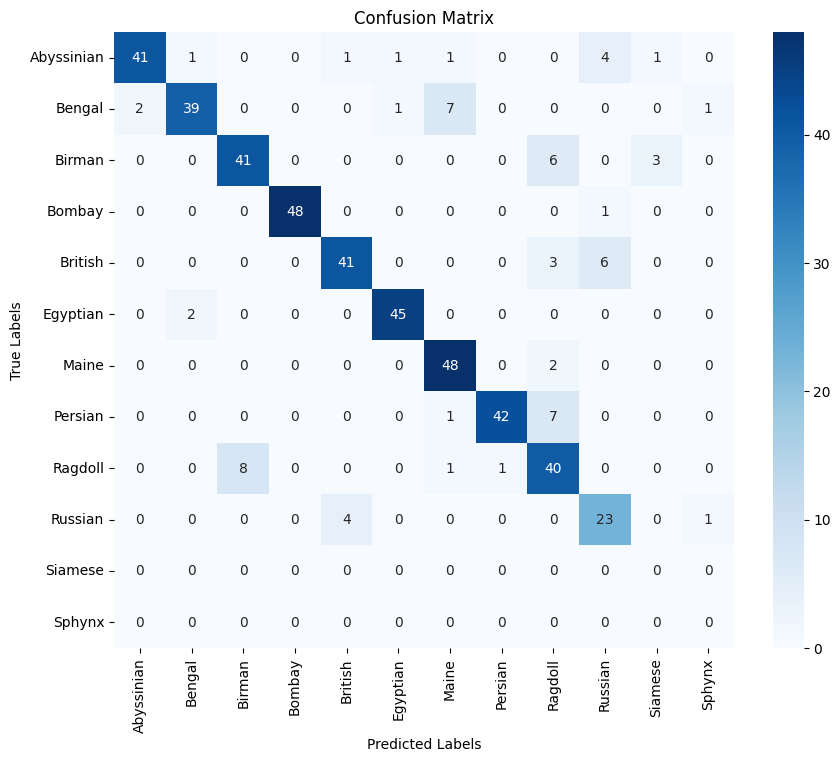

In [34]:
def evaluate_and_visualize_model(model, data_generator , class_labels):
    """
    Evaluate the trained model on validation or test data and display performance metrics.

    Args:
    - model (tf.keras.Model): The trained model to evaluate.
    - data_generator (ImageDataGenerator): Data generator containing validation/test data.

    Returns:
    - None: Prints evaluation results, confusion matrix, and classification report.
    """
    # Step 1: Model evaluation to get loss and accuracy
    print("Evaluating the model on the validation/test data...")
    loss, accuracy = model.evaluate(data_generator, verbose=1)
    print(f"\nValidation/Test Loss: {loss:.4f}")
    print(f"Validation/Test Accuracy: {accuracy:.4f}")

    # Step 2: Generate predictions for the validation/test data
    print("\nGenerating predictions...")
    y_pred_probs = model.predict(data_generator, verbose=1)  # Predicted probabilities
    y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class indices

    # Step 3: Retrieve true labels
    y_true = data_generator.classes  # True class indices

    # Step 4: Retrieve class labels for better visualization
    class_labels = list(data_generator.class_indices.keys())

    # Step 5: Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Step 6: Visualize the confusion matrix using heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


class_labels_1 = list(valid_gen_flow_cat.class_indices.keys())

# Call the function to evaluate the model
evaluate_and_visualize_model(model_1, valid_gen_flow_cat , class_labels_1)


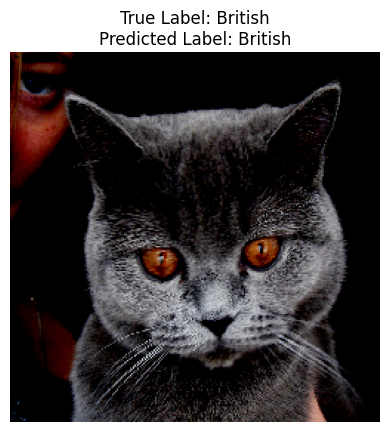

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def test_random_image(model, data_generator, class_labels):
    """
    Test the model on a random image from the dataset and display the true and predicted labels.

    Args:
    - model (tf.keras.Model): The trained model to evaluate.
    - data_generator (ImageDataGenerator): Data generator containing validation/test data.
    - class_labels (list): List of class labels.

    Returns:
    - None: Displays the image along with true and predicted labels.
    """
    # Step 1: Get a random image from the data generator
    batch = next(data_generator)
    random_index = np.random.randint(0, len(batch[0]))
    random_image = batch[0][random_index]
    true_label_index = np.argmax(batch[1][random_index])  # Assuming one-hot encoded labels
    true_label = class_labels[true_label_index]

    # Step 2: Preprocess the image for prediction
    img_array = np.expand_dims(random_image, axis=0)  # Add batch dimension

    # Step 3: Generate prediction
    y_pred_probs = model.predict(img_array, verbose=0)  # Predicted probabilities
    y_pred_index = np.argmax(y_pred_probs, axis=1)[0]  # Predicted class index
    predicted_label = class_labels[y_pred_index]

    # Step 4: Display the image and labels
    plt.imshow(random_image)
    plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()

# Call the function to test the model on a random image
test_random_image(model_1, valid_gen_flow_cat, class_labels_1)

In [ ]:
# Save the trained model to a file
def save_trained_model(model, filename):
    """
    Saves the trained Keras model to a file.

    Args:
    - model (tf.keras.Model): The trained model to be saved.
    - filename (str): The name of the file where the model will be saved. Default is "cat_model.h5".

    Returns:
    - None
    """
    try:
        # Save the model in HDF5 format
        tf.keras.models.save_model(model, filename)
        print(f"Model successfully saved to {filename}")
    except Exception as e:
        print(f"An error occurred while saving the model: {e}")

# Save the model
save_trained_model(model_1, "cat_model.h5")


Model successfully saved to cat_model.h5


# DOG Breeds

In [22]:
train_gen_flow_dog, valid_gen_flow_dog = datagen_flow_dataframe(df_dog,train_datagen,validation_datagen)

Found 3983 validated image filenames belonging to 23 classes.
Found 995 validated image filenames belonging to 23 classes.


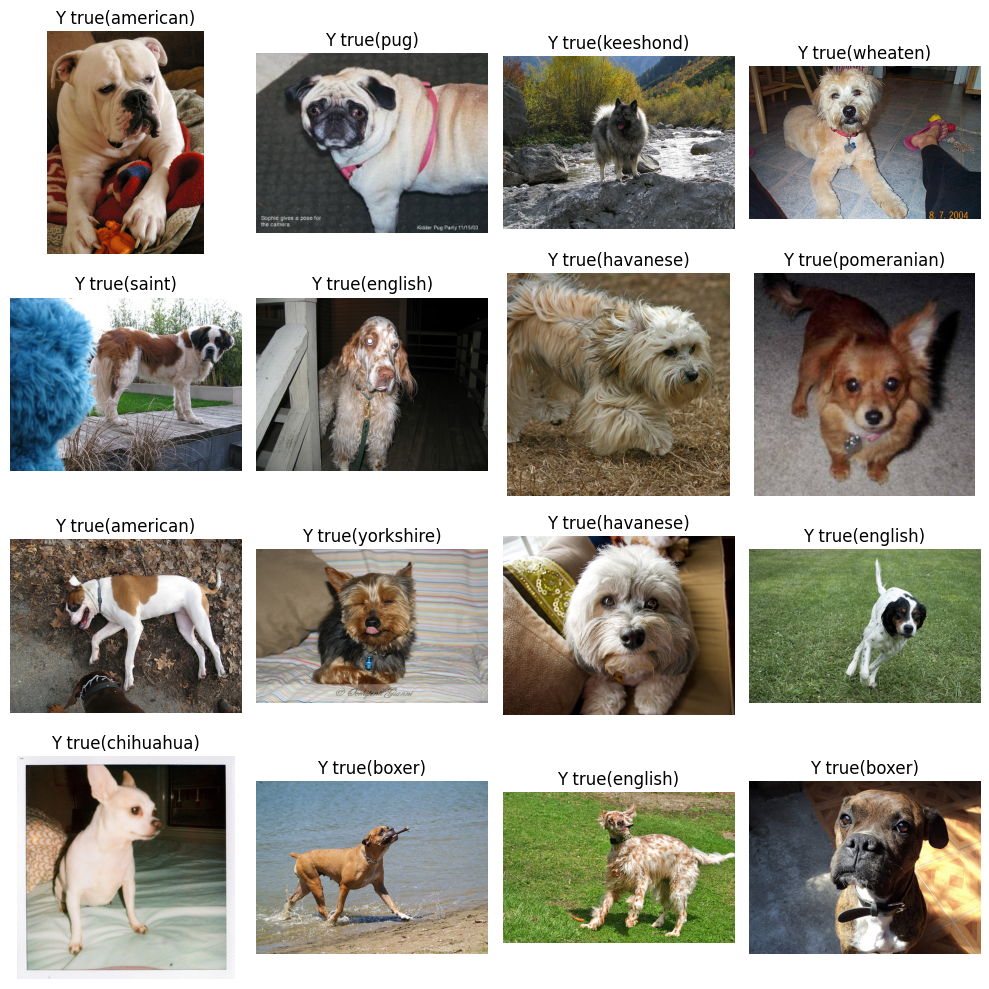

In [23]:
# Visualize classifications for the 'cat' class using the data generator
visualize_classifications(train_gen_flow_dog, row_col_len=4, figsize=(10, 10))

In [ ]:
pretrainedModel_dog = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE_CHANNELS,
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel_dog.trainable = False

inputs = pretrainedModel_dog.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel_dog.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)

outputs = tf.keras.layers.Dense(23, activation='softmax')(x)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_2.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.01), metrics=['acc'])

model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 250, 250, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 125, 125, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 125, 125, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 125, 125, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 125, 125, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 125, 125, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 125, 125, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 125, 125, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 125, 125, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 125, 125, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 125, 125, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 125, 125, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 127, 127, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 63, 63, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,431,703 (9.28 MB)

 Trainable params: 173,719 (678.59 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
train_history_2 = train_model(model_2, train_gen_flow_dog, valid_gen_flow_dog, epochs = 25 ,name="dog")

In [40]:
class_labels_2 = list(valid_gen_flow_dog.class_indices.keys())
print(class_labels_2)
len(class_labels_2)

['american', 'basset', 'beagle', 'boxer', 'chihuahua', 'english', 'german', 'great', 'havanese', 'japanese', 'keeshond', 'leonberger', 'miniature', 'newfoundland', 'pomeranian', 'pug', 'saint', 'samoyed', 'scottish', 'shiba', 'staffordshire', 'wheaten', 'yorkshire']


23

In [41]:
MODEL_PATH_2 = "/content/drive/MyDrive/Anees AI/Models/dog_model.h5"
model_2 = load_model(MODEL_PATH_2)

Evaluating the model on the validation/test data...
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - acc: 0.8547 - loss: 0.4587

Validation/Test Loss: 0.4058
Validation/Test Accuracy: 0.8804

Generating predictions...
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step

Confusion Matrix:
[[82  0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13]
 [ 0 40  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 2  3 41  0  1  2  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 6  0  0 42  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0]
 [ 1  0  0  0 44  0  0  0  0  0  0  1  2  0  2  0  0  0  0  0  0]
 [ 1  0  0  0  0 90  0  2  3  1  0  0  0  3  0  0  0  0  0  0  0]
 [ 2  0  0  0  1  3 43  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 46  0  2  0  1  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  3  0  0 44  1  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  1  1 48  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 47  3  0  0  0  0  0  0  0  0  0]


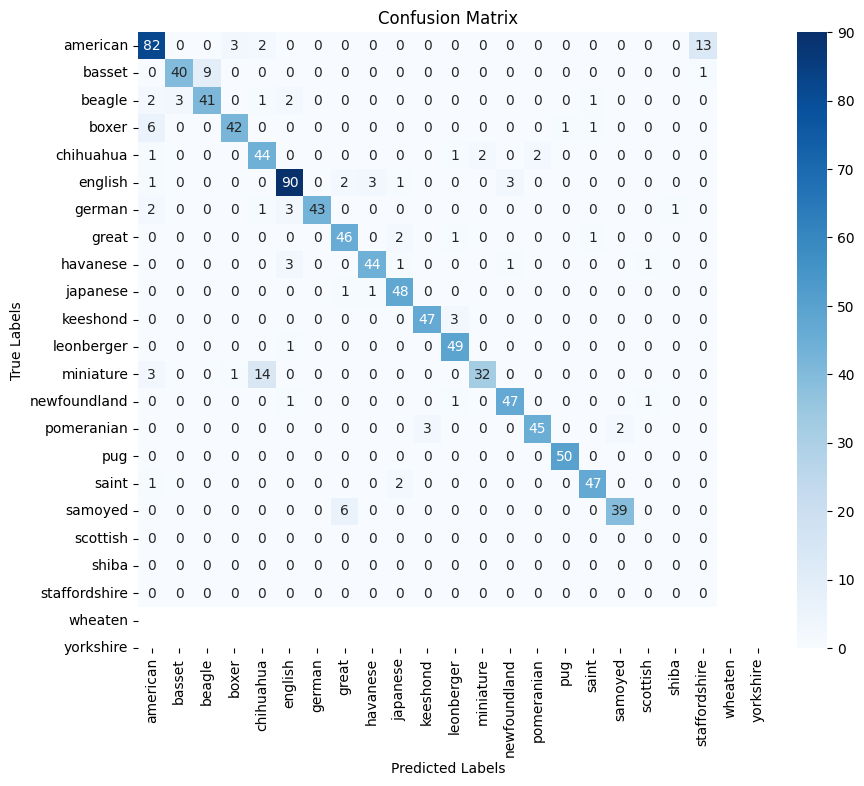

In [42]:
evaluate_and_visualize_model(model_2 ,valid_gen_flow_dog, class_labels_2 )

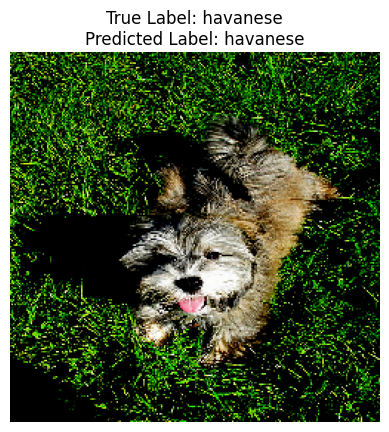

In [58]:
# Call the function to test the model on a random image
test_random_image(model_2, valid_gen_flow_dog, class_labels_2)